# Assign B cell annotations

To assemble our annotations, we'll read our clustered B cell data and assign our expert annotations to those clusters. We'll then inspect the annotations in our UMAP projections, and output final labels for these cells.

For B cells, we have two groups of cells to label - Most of the B cells were assigned labels at one resolution, and the non-effector memory B cells were assigned labels after additional, iterative clustering. So, we'll load both of these sets, remove the memory cells from the rest of the B cells, assign identities based on clusters in each, and finally concatenate all of the cell barcodes.

In [1]:
from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc

## Read subclustering results from HISE

In [2]:
cell_class = 'b-cells'

In [3]:
h5ad_uuid = '2af0d821-8f71-4951-8ad9-b0f0a2ea4ed2'
h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)

In [4]:
if not os.path.isdir(h5ad_path):
    hise_res = hisepy.reader.cache_files([h5ad_uuid])

In [5]:
h5ad_filename = os.listdir(h5ad_path)[0]
h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)

In [6]:
adata = sc.read_h5ad(h5ad_file)

In [7]:
adata

AnnData object with n_obs × n_vars = 177994 × 1209
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'file.id', 'subject.cmv', 'subject.bmi', 'celltypist.low', 'seurat.l1', 'seurat.l1.score', 'seurat.l2', 'seurat.l2.score', 'seurat.l2.5', 'seurat.l2.5.score', 'seurat.l3', 'seurat.l3.score', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden', 'leiden_resolution_1', 'leiden_reso

## Read memory cell subclustering results from HISE

In [8]:
mem_uuid = '855fd8a5-0d80-47d0-806d-98440767b8c4'
mem_path = '/home/jupyter/cache/{u}'.format(u = mem_uuid)

In [9]:
if not os.path.isdir(mem_path):
    hise_res = hisepy.reader.cache_files([mem_path])

In [10]:
mem_filename = os.listdir(mem_path)[0]
mem_file = '{p}/{f}'.format(p = mem_path, f = mem_filename)

In [11]:
mem_adata = sc.read_h5ad(mem_file)

In [12]:
mem_adata

AnnData object with n_obs × n_vars = 49408 × 2062
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'file.id', 'subject.cmv', 'subject.bmi', 'celltypist.low', 'seurat.l1', 'seurat.l1.score', 'seurat.l2', 'seurat.l2.score', 'seurat.l2.5', 'seurat.l2.5.score', 'seurat.l3', 'seurat.l3.score', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden', 'leiden_resolution_1', 'leiden_resol

## Subset non-memory cells

In [13]:
drop_lgl = [not x for x in adata.obs['barcodes'].isin(mem_adata.obs['barcodes'])]

In [14]:
nonmem_adata = adata[drop_lgl].copy()

In [15]:
nonmem_adata.shape

(128586, 1209)

## Read non-memory annotations

In [16]:
anno_uuid = '5db32b3d-cade-4977-b6ba-68aed2e7ee06'
anno_path = '/home/jupyter/cache/{u}'.format(u = anno_uuid)

In [17]:
if not os.path.isdir(anno_path):
    hise_res = hisepy.reader.cache_files([anno_uuid])

In [18]:
anno_filename = os.listdir(anno_path)[0]
anno_file = '{p}/{f}'.format(p = anno_path, f = anno_filename)

In [19]:
anno = pd.read_csv(anno_file, index_col = 0)

In [20]:
anno.head()

,ms_leiden_2,AIFI_L3,AIFI_L1,AIFI_L1_Final,AIFI_L2,AIFI_L2_Final,AIFI_L3_Final
0,0,Core naive B cell,B cell,Yes,Naive B cell,Yes,Yes
1,1,Core naive B cell,B cell,Yes,Naive B cell,Yes,Yes
2,2,Core naive B cell,B cell,Yes,Naive B cell,Yes,Yes
3,3,CD27+ effector B cell,B cell,Yes,Effector B cell,Yes,Yes
4,4,Core naive B cell,B cell,Yes,Naive B cell,Yes,Yes


## Assign non-memory labels

In [21]:
join_col = 'ms_leiden_2'

In [22]:
anno[join_col] = anno[join_col].astype('string').astype('category')

In [23]:
obs = nonmem_adata.obs

In [24]:
sum(obs[join_col].isin(anno[join_col]))

128586

In [25]:
nonmem_anno = obs.merge(anno, how = 'left', on = join_col)

In [26]:
nonmem_anno.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,ms_leiden_2,AIFI_L3,AIFI_L1,AIFI_L1_Final,AIFI_L2,AIFI_L2_Final,AIFI_L3_Final
0,cf72a14a48b611ea8957bafe6d70929e,B001,bestial_fireless_rottweiler,cf72a14a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,904,58,10269,...,7,15,18,21,T_B doublet,T_B doublet,Yes,T_B doublet,Yes,Yes
1,cf73500e48b611ea8957bafe6d70929e,B001,stressed_wishful_flea,cf73500e48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1085,71,12422,...,1,0,0,0,Core naive B cell,B cell,Yes,Naive B cell,Yes,Yes
2,cf73694a48b611ea8957bafe6d70929e,B001,silicone_nonsolar_snowgeese,cf73694a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1152,198,11355,...,5,8,10,15,CD27+ effector B cell,B cell,Yes,Effector B cell,Yes,Yes
3,cf73fbee48b611ea8957bafe6d70929e,B001,luxuriant_overrated_gypsymoth,cf73fbee48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1769,245,18105,...,4,3,3,5,Transitional B cell,B cell,Yes,Transitional B cell,Yes,Yes
4,cf74ae2c48b611ea8957bafe6d70929e,B001,real_bighearted_kitty,cf74ae2c48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,692,83,5468,...,1,0,0,0,Core naive B cell,B cell,Yes,Naive B cell,Yes,Yes


## Read memory annotations

In [27]:
mem_anno_uuid = '8054b2e0-a5cc-49ec-b120-99c46b9097a4'
mem_anno_path = '/home/jupyter/cache/{u}'.format(u = mem_anno_uuid)

In [28]:
if not os.path.isdir(mem_anno_path):
    hise_res = hisepy.reader.cache_files([mem_anno_uuid])

In [29]:
mem_anno_filename = os.listdir(mem_anno_path)[0]
mem_anno_file = '{p}/{f}'.format(p = mem_anno_path, f = mem_anno_filename)

In [30]:
mem_anno = pd.read_csv(mem_anno_file, index_col = 0)

In [31]:
mem_anno.head()

,ms_leiden_2.5,AIFI_L3,AIFI_L1,AIFI_L1_Final,AIFI_L2,AIFI_L2_Final,AIFI_L3_Final
0,0,Core memory B cell,B cell,Yes,Memory B cell,Yes,Yes
1,1,Core memory B cell,B cell,Yes,Memory B cell,Yes,Yes
2,2,Core memory B cell,B cell,Yes,Memory B cell,Yes,Yes
3,3,Core memory B cell,B cell,Yes,Memory B cell,Yes,Yes
4,4,Core memory B cell,B cell,Yes,Memory B cell,Yes,Yes


## Assign memory labels

In [32]:
join_col = 'ms_leiden_2.5'

In [33]:
mem_anno[join_col] = mem_anno[join_col].astype('string').astype('category')

In [34]:
obs = mem_adata.obs

In [35]:
sum(obs[join_col].isin(mem_anno[join_col]))

49408

In [36]:
mem_anno = obs.merge(mem_anno, how = 'left', on = join_col)

In [37]:
mem_anno.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,ms_leiden_2,umap_1,umap_2,ms_leiden_2.5,AIFI_L3,AIFI_L1,AIFI_L1_Final,AIFI_L2,AIFI_L2_Final,AIFI_L3_Final
0,cf720af048b611ea8957bafe6d70929e,B001,patterny_untalented_halcyon,cf720af048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,928,66,7856,...,3,NaN,NaN,9,Core memory B cell,B cell,Yes,Memory B cell,Yes,Yes
1,cf754ae448b611ea8957bafe6d70929e,B001,unstable_graspable_ibis,cf754ae448b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,715,103,5414,...,17,NaN,NaN,9,Core memory B cell,B cell,Yes,Memory B cell,Yes,Yes
2,cf78473048b611ea8957bafe6d70929e,B001,burly_backward_tuatara,cf78473048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1372,338,17586,...,1,NaN,NaN,10,Type 2 polarized memory B cell,B cell,Yes,Memory B cell,Yes,Yes
3,cf79279a48b611ea8957bafe6d70929e,B001,illadvised_applicable_annelid,cf79279a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,757,207,8651,...,1,NaN,NaN,0,Core memory B cell,B cell,Yes,Memory B cell,Yes,Yes
4,cf7a6a1048b611ea8957bafe6d70929e,B001,earthborn_blusterous_firecrest,cf7a6a1048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1227,203,12778,...,17,NaN,NaN,1,Core memory B cell,B cell,Yes,Memory B cell,Yes,Yes


## Concatenate annotations

In [38]:
anno = pd.concat([nonmem_anno, mem_anno], axis = 0)

In [39]:
anno = anno[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]

## Add to AnnData to preview assignments

In [40]:
anno = anno.set_index('barcodes')

In [41]:
obs = adata.obs
obs = obs.merge(anno, how = 'left', left_index = True, right_index = True)

In [42]:
adata.obs = obs

In [43]:
adata.obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,log1p_total_counts_mito,pct_counts_mito,leiden,leiden_resolution_1,leiden_resolution_1.5,leiden_resolution_2,ms_leiden_2,AIFI_L1,AIFI_L2,AIFI_L3
barcodes,,,,,,,,,,,,,,,,,,,,,
cf720af048b611ea8957bafe6d70929e,cf720af048b611ea8957bafe6d70929e,B001,patterny_untalented_halcyon,cf720af048b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,928,66,7856,...,4.204693,2.798982,10,2,2,2,3,B cell,Memory B cell,Core memory B cell
cf72a14a48b611ea8957bafe6d70929e,cf72a14a48b611ea8957bafe6d70929e,B001,bestial_fireless_rottweiler,cf72a14a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,904,58,10269,...,4.077537,1.968103,7,7,15,18,21,T_B doublet,T_B doublet,T_B doublet
cf73500e48b611ea8957bafe6d70929e,cf73500e48b611ea8957bafe6d70929e,B001,stressed_wishful_flea,cf73500e48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1085,71,12422,...,4.276666,1.978267,7,1,0,0,0,B cell,Naive B cell,Core naive B cell
cf73694a48b611ea8957bafe6d70929e,cf73694a48b611ea8957bafe6d70929e,B001,silicone_nonsolar_snowgeese,cf73694a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1152,198,11355,...,5.293305,5.899881,10,5,8,10,15,B cell,Effector B cell,CD27+ effector B cell
cf73fbee48b611ea8957bafe6d70929e,cf73fbee48b611ea8957bafe6d70929e,B001,luxuriant_overrated_gypsymoth,cf73fbee48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1769,245,18105,...,5.505332,4.552211,7,4,3,3,5,B cell,Transitional B cell,Transitional B cell


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

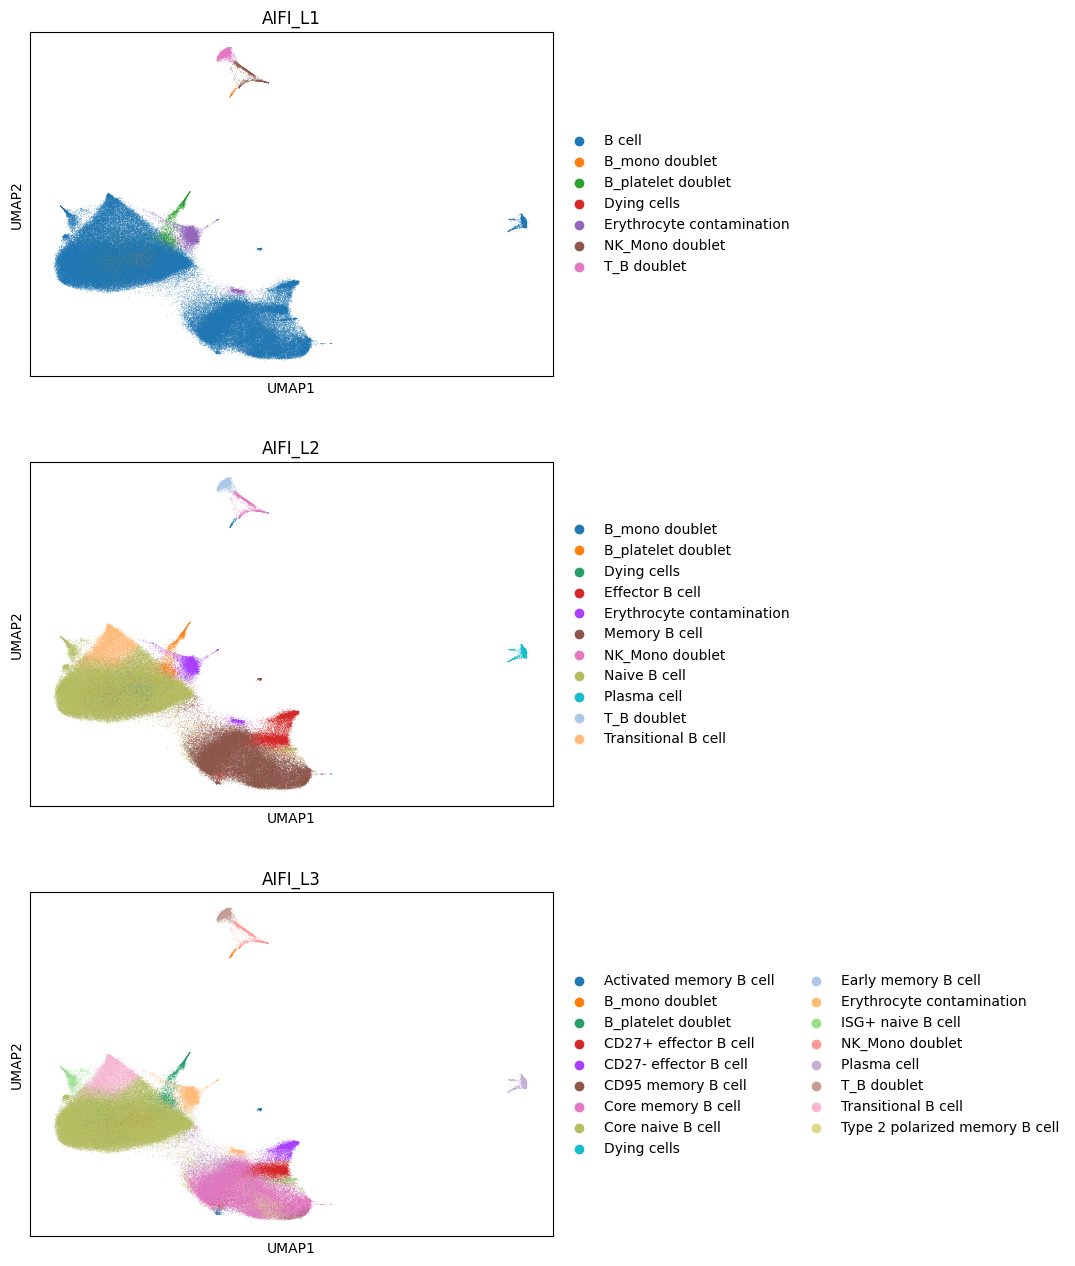

In [44]:
sc.pl.umap(adata, color = ['AIFI_L1', 'AIFI_L2', 'AIFI_L3'], ncols = 1)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting

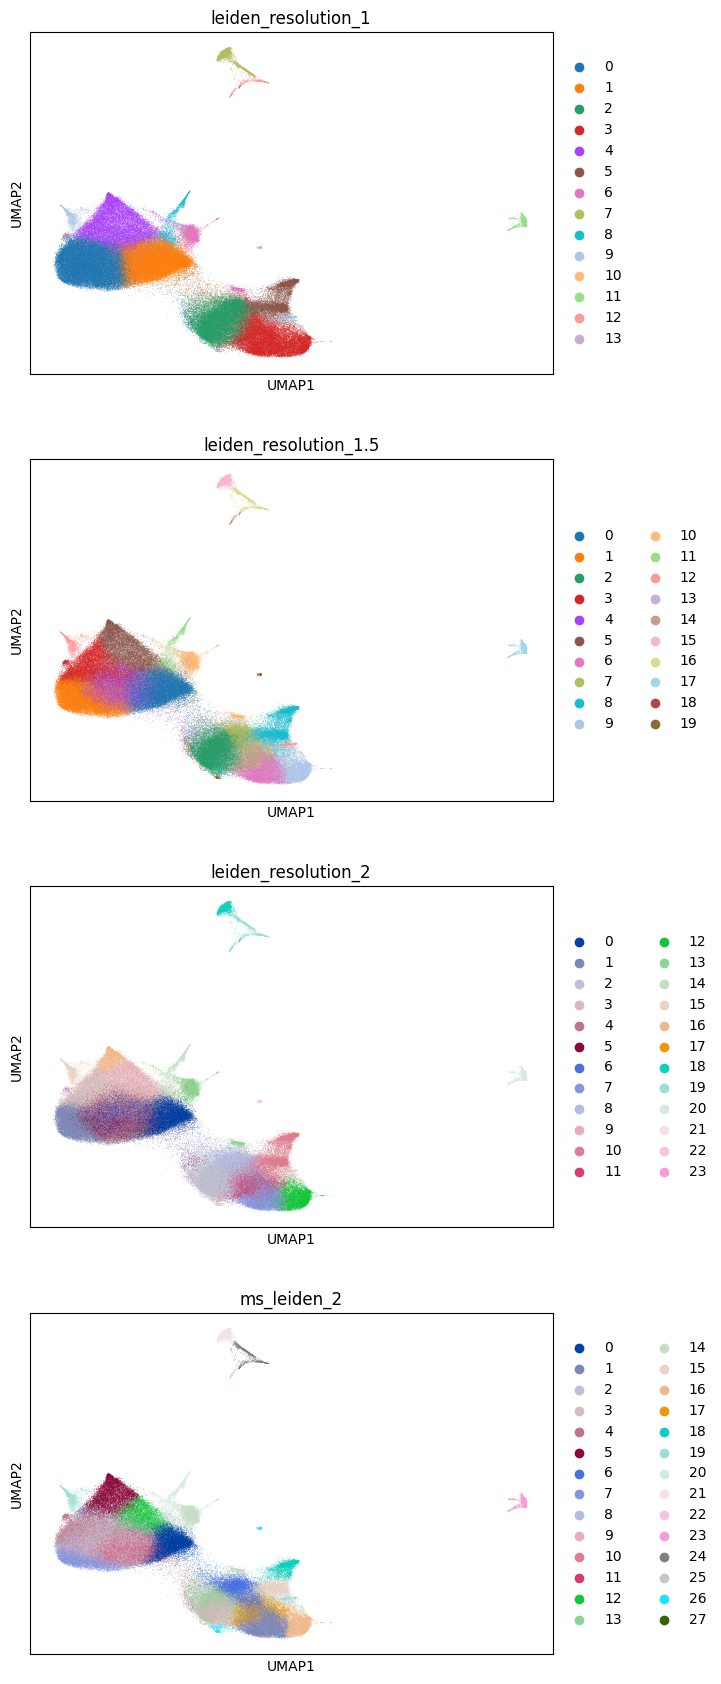

In [45]:
sc.pl.umap(adata, 
           color = ['leiden_resolution_1',
                    'leiden_resolution_1.5',
                    'leiden_resolution_2',
                    'ms_leiden_2'],
           ncols = 1)

## Output final annotations

In [46]:
anno = adata.obs[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]
anno = anno.reset_index(drop = True)

In [47]:
anno.head()

,barcodes,AIFI_L1,AIFI_L2,AIFI_L3
0,cf720af048b611ea8957bafe6d70929e,B cell,Memory B cell,Core memory B cell
1,cf72a14a48b611ea8957bafe6d70929e,T_B doublet,T_B doublet,T_B doublet
2,cf73500e48b611ea8957bafe6d70929e,B cell,Naive B cell,Core naive B cell
3,cf73694a48b611ea8957bafe6d70929e,B cell,Effector B cell,CD27+ effector B cell
4,cf73fbee48b611ea8957bafe6d70929e,B cell,Transitional B cell,Transitional B cell


In [48]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [49]:
out_csv = '{p}/ref_pbmc_barcode_labels_{c}_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())

In [50]:
anno.to_csv(out_csv, index = False)

In [51]:
out_parquet = '{p}/ref_pbmc_barcode_labels_{c}_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())

In [52]:
anno.to_parquet(out_parquet, index = False)

## Upload annotations to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [53]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'B cell barcode annotations {d}'.format(d = date.today())

In [56]:
in_files = [h5ad_uuid, mem_uuid, anno_uuid, mem_anno_uuid]

In [57]:
in_files

['2af0d821-8f71-4951-8ad9-b0f0a2ea4ed2',
 '855fd8a5-0d80-47d0-806d-98440767b8c4',
 '5db32b3d-cade-4977-b6ba-68aed2e7ee06',
 '8054b2e0-a5cc-49ec-b120-99c46b9097a4']

In [58]:
out_files = [out_csv, out_parquet]

In [59]:
out_files

['output/ref_pbmc_barcode_labels_b-cells_2024-02-27.csv',
 'output/ref_pbmc_barcode_labels_b-cells_2024-02-27.parquet']

In [60]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

you are trying to upload file_ids... ['output/ref_pbmc_barcode_labels_b-cells_2024-02-27.csv', 'output/ref_pbmc_barcode_labels_b-cells_2024-02-27.parquet']. Do you truly want to proceed?


(y/n) y


{'trace_id': '0a92762b-7298-4ba4-8bb3-7f8deb12c89b',
 'files': ['output/ref_pbmc_barcode_labels_b-cells_2024-02-27.csv',
  'output/ref_pbmc_barcode_labels_b-cells_2024-02-27.parquet']}

In [61]:
import session_info
session_info.show()